1 清洗数据，划分载客、空车，提取OD

In [ ]:
def extractOD(dir,file):
    import pandas as pd
    import numpy as np
    import transbigdata as tbd
    read_path=dir+file
    date=file[0:8]
    #读取文件，格式化处理文件
    colname=['traId','latitude','longitude','status','time','timestamp','osm_fid','mx','my']
    df=pd.read_csv(read_path,names=colname)
    df.dropna(inplace=True)
    df.sort_values(by=['time','traId'])
    df['time']=pd.to_datetime(df['time'],format='%Y/%m/%d %H:%M:%S')

    #清洗数据
    dropNoisyDf=tbd.clean_taxi_status(df, col=['traId', 'time', 'status'])

    #生成OD矩阵
    odDf=tbd.taxigps_to_od(dropNoisyDf, col=['traId', 'time', 'mx','my', 'status'])

    #计算OD距离
    odDf['distance']=tbd.getdistance(odDf['slon'], odDf['slat'], odDf['elon'], odDf['elat'])

    #提取轨迹
    deliverDf,emptyDf=tbd.taxigps_traj_point(dropNoisyDf, odDf, col=['traId', 'time', 'mx','my', 'status'])

    del df
    del dropNoisyDf

    #统计轨迹经过的路段数量
    segmentNumber=deliverDf.groupby(by='ID')['osm_fid'].nunique().reset_index()
    segmentNumber.rename({'osm_fid':'segmentNumber'},axis=1,inplace=True)

    #绘图
    segmentNumber=segmentNumber.sort_values(by='segmentNumber')
    segmentNumberSub=segmentNumber[segmentNumber['segmentNumber']<150]

    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties           
    font = FontProperties(family='Ubuntu')
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False)
    plt.grid(True,axis='both') # 添加网格线
    bar_plot = ax.hist(segmentNumberSub['segmentNumber'], label='Mean Day Count', bins=100)
    cumulative_count = np.cumsum(segmentNumberSub['segmentNumber']) / np.sum(segmentNumberSub['segmentNumber'])
    ax2 = ax.twinx()
    line_plot, = ax2.plot(segmentNumberSub['segmentNumber'],cumulative_count, linestyle='-', color='red', label='Cumulative Probability')

    ax.set_title(date, fontproperties=font, fontsize=12)
    ax.set_xlabel('segment number', fontproperties=font, fontsize=10)
    ax.set_ylabel('count', fontproperties=font, fontsize=10)
    ax2.set_ylabel('Cumulative Probability', fontproperties=font, fontsize=10)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='right', prop={'size': 8})


    deliver_path=f'/media/wtong/文件/dataSet/chengduTaxi/deliver/{date}.csv'
    od_path=f'/media/wtong/文件/dataSet/chengduTaxi/od/{date}.csv'
    image_path=f'/media/wtong/文件/dataSet/chengduTaxi/image/{date}.png'
    #存储轨迹
    deliverDf.to_csv(deliver_path,index=False)
    #存储OD
    odDf.to_csv(od_path,index=False)
    #存储图片
    plt.savefig(image_path,dpi=120)

import os


dir='/media/wtong/文件/dataSet/chengduTaxi/combine/'
filelist=os.listdir(dir)

for file in filelist:
    extractOD(dir,file)

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


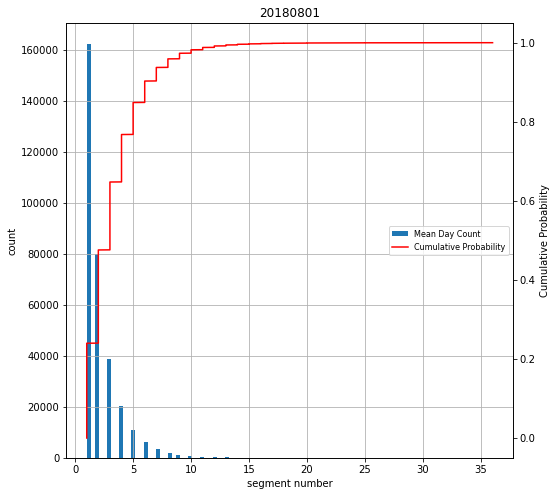

In [1]:
import transbigdata as tbd
import pandas as pd
import numpy as np
date=20180801
file='E:/dataSet/wuhanTraj0801/'

#读文件
data=pd.read_csv(file+'origin/20180801.csv',header=0,index_col=0)
data['status']=1
data['time'] = pd.to_datetime(data['timestamp'])

#补0
'''
无载客信息的要添加行程起终点
'''

first_records = data.groupby('traj').first().reset_index()
first_records['status']=0
first_records['time']=first_records['time']+ pd.Timedelta(seconds=-5)

last_records = data.groupby('traj').last().reset_index()
last_records['status']=0
last_records['time']=last_records['time']+ pd.Timedelta(seconds=5)


conData = pd.concat([data, first_records,last_records], axis=0)
odDf=tbd.taxigps_to_od(conData, col=['traj', 'time', 'mx','my', 'status'])
odDf['distance']=tbd.getdistance(odDf['slon'], odDf['slat'], odDf['elon'], odDf['elat'])

#提取轨迹
deliverDf,emptyDf=tbd.taxigps_traj_point(conData, odDf, col=['traj', 'time', 'mx','my', 'status'])


#统计轨迹经过的路段数量
segmentNumber=deliverDf.groupby(by='ID')['idnew'].nunique().reset_index()
segmentNumber.rename({'idnew':'segmentNumber'},axis=1,inplace=True)

#绘图
segmentNumber=segmentNumber.sort_values(by='segmentNumber')
segmentNumberSub=segmentNumber[segmentNumber['segmentNumber']<100]

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties           
font = FontProperties(family='Ubuntu')
fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False)
plt.grid(True,axis='both') # 添加网格线
bar_plot = ax.hist(segmentNumberSub['segmentNumber'], label='Mean Day Count', bins=100)
cumulative_count = np.cumsum(segmentNumberSub['segmentNumber']) / np.sum(segmentNumberSub['segmentNumber'])
ax2 = ax.twinx()
line_plot, = ax2.plot(segmentNumberSub['segmentNumber'],cumulative_count, linestyle='-', color='red', label='Cumulative Probability')

ax.set_title(date, fontproperties=font, fontsize=12)
ax.set_xlabel('segment number', fontproperties=font, fontsize=10)
ax.set_ylabel('count', fontproperties=font, fontsize=10)
ax2.set_ylabel('Cumulative Probability', fontproperties=font, fontsize=10)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='right', prop={'size': 8})

deliver_path=f'E:/dataSet/wuhanTraj0801/deliver/{date}.csv'
od_path=f'E:/dataSet/wuhanTraj0801/od/{date}.csv'
image_path=f'E:/dataSet/wuhanTraj0801/image/{date}.png'
#存储轨迹
deliverDf.to_csv(deliver_path,index=False)
#存储OD
odDf.to_csv(od_path,index=False)
#存储图片
plt.savefig(image_path,dpi=120)

2 将OD聚合到网格上并计算距离

In [6]:
import transbigdata as tbd
import numpy as np
import pandas as pd
import geopandas as gpd
import os

fatherdir='/media/wtong/文件/dataSet/wuhanTaxi/WH_match_5659road/'
deliver_path='allmatch/'
grid_path='CGCSroad/CGCSgridshp.shp'
gridDf=gpd.read_file(fatherdir+grid_path)


weeklist=['weekday','weekend']
#tbd.getdistance(od_gdf[''], od_gdf[''], od_gdf[''], od_gdf[''])#测距
def lengCalculate(row):
    length=((row['left_x']-row['bottom_x'])**2+ (row['left_y']-row['bottom_y'])**2)**0.5
    return length

for week in weeklist:
    all=pd.DataFrame()
    count=0
    od_path=fatherdir+f'od/{week}/'
    od_filelist=os.listdir(od_path)
    for file in od_filelist:
        #date=file[0:8]
        df=pd.read_csv(od_path+file,header=0)
        deliverDf=pd.read_csv(fatherdir+deliver_path+file,header=0)

        deliverDf=deliverDf[deliverDf['flag']==1]
        df=df[df['ID'].isin(deliverDf['ID'])]

        deliverDf.to_csv(fatherdir+f'filter/deliver/{week}/{file}',index=False)
        df.to_csv(fatherdir+f'filter/od/{week}/{file}',index=False)

        count+=1
        all=pd.concat([all,df],axis=0)
        del deliverDf
        del df
    print(count)
    od_gdf = tbd.odagg_shape(all,gridDf,round_accuracy=6)
    od_gdf['count']=od_gdf['count']/count
    od_gdf['distance']=od_gdf.apply(lengCalculate, axis=1)

    od_gdf.to_file(fatherdir+f'filter/od_file/{week}.shp',driver='ESRI Shapefile',encoding='utf-8')

5


/home/wtong/anaconda3/lib/python3.11/site-packages/transbigdata/odprocess.py:187: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4547

  d = gpd.sjoin(d, shape)


2


/home/wtong/anaconda3/lib/python3.11/site-packages/transbigdata/odprocess.py:187: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4547

  d = gpd.sjoin(d, shape)


3 按15分钟划分轨迹

In [15]:
#生成15min序列
import pandas as pd
import numpy as np
import transbigdata as tbd
read_path='/media/wtong/文件/dataSet/chengduTaxi/deliver/20140818.csv'
#date=file[0:8]
#读取文件，格式化处理文件
#olname=['traId','latitude','longitude','status','time','timestamp','osm_fid','mx','my']
df=pd.read_csv(read_path,header=0)
df.dropna(inplace=True)
df.sort_values(by=['time','traId'])
df['time']=pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S')


def calculateTimeId(times):
    hour=times.hour
    minute=times.minute

    timeId=(hour*60+minute)//15+1
    
    return timeId


df['timeID']=df['time'].apply(calculateTimeId)
segmentNumber=df.groupby(by=['timeID','traId'])['osm_fid'].nunique().reset_index()
segmentNumber.rename({'osm_fid':'segmentNumber'},axis=1,inplace=True)
segmentNumber=segmentNumber.sort_values(by='segmentNumber')
#segmentNumberSub=segmentNumber[segmentNumber['segmentNumber']<150]

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties           
font = FontProperties(family='Ubuntu')
fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False)
plt.grid(True,axis='both') # 添加网格线
bar_plot = ax.hist(segmentNumber['segmentNumber'], label='Mean Day Count', bins=100)
cumulative_count = np.cumsum(segmentNumber['segmentNumber']) / np.sum(segmentNumber['segmentNumber'])
ax2 = ax.twinx()
line_plot, = ax2.plot(segmentNumber['segmentNumber'],cumulative_count, linestyle='-', color='red', label='Cumulative Probability')

,traId,latitude,longitude,status,time,timestamp,osm_fid,mx,my,ID,flag,timeID
0,1,30.688952,104.055989,1,2014-08-18 06:30:24,1.408343e+09,27968.0,104.055972,30.689041,0.0,1.0,27
1,1,30.688952,104.055989,1,2014-08-18 06:31:24,1.408343e+09,27968.0,104.055972,30.689041,0.0,1.0,27
2,1,30.688952,104.055989,1,2014-08-18 06:32:25,1.408344e+09,27968.0,104.055972,30.689041,0.0,1.0,27
3,1,30.688952,104.055989,1,2014-08-18 06:33:25,1.408344e+09,27968.0,104.055972,30.689041,0.0,1.0,27
4,1,30.688952,104.055989,1,2014-08-18 06:34:25,1.408344e+09,27968.0,104.055972,30.689041,0.0,1.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...
24248728,14704,30.594288,104.063398,1,2014-08-18 23:40:25,1.408405e+09,88071.0,104.063725,30.594298,436329.0,1.0,95
24248729,14704,30.594331,104.062215,1,2014-08-18 23:40:35,1.408405e+09,49517.0,104.061556,30.594325,436329.0,1.0,95
24248730,14704,30.594338,104.061879,1,2014-08-18 23:40:45,1.408405e+09,49516.0,104.061556,30.594334,436329.0,1.0,95
24248731,14704,30.594352,104.061477,1,2014-08-18 23:40:55,1.408405e+09,49516.0,104.061556,30.594354,436329.0,1.0,95


In [1]:
import pandas as pd
m=pd.read_csv('E:/dataSet/chengduTaxi/deliver/20140824.csv')
m

,traId,latitude,longitude,status,time,timestamp,osm_fid,mx,my,ID,flag
0,1,30.652514,104.123367,1,2014-08-24 07:05:40,1.408864e+09,58453.0,104.123376,30.652489,0.0,1.0
1,1,30.652514,104.123367,1,2014-08-24 07:06:10,1.408864e+09,58453.0,104.123376,30.652489,0.0,1.0
2,1,30.652514,104.123367,1,2014-08-24 07:06:41,1.408864e+09,58453.0,104.123376,30.652489,0.0,1.0
3,1,30.652514,104.123367,1,2014-08-24 07:07:11,1.408864e+09,58453.0,104.123376,30.652489,0.0,1.0
4,1,30.652514,104.123367,1,2014-08-24 07:07:42,1.408864e+09,58453.0,104.123376,30.652489,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
10090884,14796,30.687222,104.040794,1,2014-08-24 23:54:34,1.408924e+09,29180.0,104.040638,30.687073,220468.0,1.0
10090885,14796,30.689261,104.039280,1,2014-08-24 23:54:56,1.408924e+09,55874.0,104.039148,30.689417,220468.0,1.0
10090886,14796,30.688921,104.039250,1,2014-08-24 23:55:09,1.408925e+09,67629.0,104.039259,30.688926,220468.0,1.0
10090887,14796,30.688593,104.039366,1,2014-08-24 23:55:12,1.408925e+09,60762.0,104.039335,30.688569,220468.0,1.0


In [25]:
import pandas as pd
import numpy as np
import os

deliverdir='/media/wtong/文件/dataSet/wuhanTaxi/calspeed/deliver/'
emptydir='/media/wtong/文件/dataSet/wuhanTaxi/calspeed/empty/'
savefile='/media/wtong/文件/dataSet/wuhanTaxi/calspeed/concat/'
filelist=os.listdir(dir)


for file in filelist:
    deliverdf=pd.read_csv(deliverdir+file,header=0,index_col=None,sep=';')
    emptydf=pd.read_csv(emptydir+file,header=0,index_col=0,sep=',')
    emptydf['ID']=emptydf['ID']+100000000
    emptydf.drop('indexcol',axis=1,inplace=True)

    df=pd.concat([deliverdf,emptydf],axis=0)
    
    
    df.to_csv(savefile+file,sep=';',header=True,index=False)

In [7]:
import pandas as pd
import numpy as np
import os

dir='/media/wtong/文件/matchdata/data/dealmatch/'
save='/media/wtong/文件/matchdata/data/save/'
filelist=os.listdir(dir)
for file in filelist:

    df=pd.read_csv(dir+file,header=0,index_col=None,sep=',')
    #df.sort_values(by='ID')
    df=df[df['traId']!='traId']
    df.to_csv(save+file,index=False)


/tmp/ipykernel_5049/1411326018.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(dir+file,header=0,index_col=None,sep=',')


In [9]:
import pandas as pd
import numpy as np
import os

#dir='/media/wtong/文件/matchdata/data/dealmatch/'
save='/media/wtong/文件/matchdata/data/save/'
file='20180702.csv'
dir='/media/wtong/文件/dataSet/wuhanTaxi/WH_match_5659road/concatBeforeMacth/20180702.csv'
df=pd.read_csv(save+file,header=0,index_col=None,sep=',')
df.sort_values(by='flag')
df

,traId,timestamp,pass1,longitude,latitude,pass2,status,speed,time,ID,flag,osm_fid,osm_idnew,mx,my
0,1000001,1.530499e+09,6280.0,540114.866693,3.370268e+06,1.0,1.0,8.157021e+00,2018/07/02 02:29:26,0.0,1.0,74,74,540115.864320,3.370263e+06
1,1000001,1.530499e+09,6280.0,540114.866693,3.370268e+06,1.0,1.0,8.157021e+00,2018/07/02 02:29:26,0.0,1.0,74,74,540115.864320,3.370263e+06
2,1000001,1.530499e+09,6280.0,540711.539875,3.370376e+06,0.0,1.0,2.902412e+01,2018/07/02 02:30:41,0.0,1.0,74,74,540711.229850,3.370378e+06
3,1000001,1.530499e+09,6280.0,540711.539875,3.370376e+06,0.0,1.0,2.902412e+01,2018/07/02 02:30:41,0.0,1.0,74,74,540711.229850,3.370378e+06
4,1000001,1.530499e+09,6281.0,541270.987292,3.370476e+06,0.0,1.0,2.902005e+01,2018/07/02 02:31:51,0.0,1.0,83,83,541270.385136,3.370480e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178170,1017199,1.530546e+09,12372.0,533303.008010,3.382978e+06,1.0,0.0,1.562921e-01,2018/07/02 15:43:25,100692210.0,0.0,4519,1529,533248.622407,3.382909e+06
10178171,1017199,1.530547e+09,12372.0,533310.668793,3.382972e+06,1.0,0.0,1.167377e+00,2018/07/02 15:48:56,100692210.0,0.0,4519,1529,533256.267707,3.382903e+06
10178172,1017199,1.530547e+09,12372.0,533349.114618,3.382941e+06,0.0,0.0,1.378786e+00,2018/07/02 15:51:04,100692210.0,0.0,4519,1529,533294.737540,3.382873e+06
10178173,1017199,1.530547e+09,12372.0,533297.552192,3.382982e+06,1.0,1.0,1.266443e+00,2018/07/02 15:53:56,100692210.0,0.0,1529,1529,533243.211789,3.382914e+06


In [1]:
import pandas as pd
df=pd.read_csv('/media/wtong/文件/dataSet/20180702.csv')


/tmp/ipykernel_3694/2909151857.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/media/wtong/文件/dataSet/20180702.csv')


TypeError: '<' not supported between instances of 'float' and 'str'

In [8]:
#df['timestamp']=df['timestamp'].astype('float')
df=df[df['timestamp']!='timestamp']
df

,traId,timestamp,pass1,longitude,latitude,pass2,status,speed,time,ID,flag,osm_fid,osm_idnew,mx,my
0,1000001,1530498566.0,6280.0,540114.866693,3370268.253588,1.0,1.0,8.157021,2018/07/02 02:29:26,0.0,1.0,74,74,540115.86432,3370262.65184
1,1000001,1530498566.0,6280.0,540114.866693,3370268.253588,1.0,1.0,8.157021,2018/07/02 02:29:26,0.0,1.0,74,74,540115.86432,3370262.65184
2,1000001,1530498641.2,6280.0,540711.539875,3370376.069632,0.0,1.0,29.02412,2018/07/02 02:30:41,0.0,1.0,74,74,540711.22985,3370377.82088
3,1000001,1530498641.2,6280.0,540711.539875,3370376.069632,0.0,1.0,29.02412,2018/07/02 02:30:41,0.0,1.0,74,74,540711.22985,3370377.82088
4,1000001,1530498711.7,6281.0,541270.987292,3370476.184487,0.0,1.0,29.020054,2018/07/02 02:31:51,0.0,1.0,83,83,541270.385136,3370479.67376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178269,1017199,1530546205.0,12372.0,533303.00801,3382977.974944,1.0,0.0,0.156292,2018/07/02 15:43:25,100692210.0,0.0,4519,1529,533248.622407,3382909.32126
10178270,1017199,1530546536.0,12372.0,533310.668793,3382971.896582,1.0,0.0,1.167377,2018/07/02 15:48:56,100692210.0,0.0,4519,1529,533256.267707,3382903.26796
10178271,1017199,1530546664.14,12372.0,533349.114618,3382941.392175,0.0,0.0,1.378786,2018/07/02 15:51:04,100692210.0,0.0,4519,1529,533294.73754,3382872.8088
10178272,1017199,1530546836.0,12372.0,533297.552192,3382982.303802,1.0,1.0,1.266443,2018/07/02 15:53:56,100692210.0,0.0,1529,1529,533243.211789,3382913.60521


In [10]:
df.sort_values(by='timestamp')

/tmp/ipykernel_3694/2783623282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp']=df['timestamp'].astype('float')


In [5]:
import pandas as pd
df=pd.read_csv('/media/wtong/文件/matchdata/data/reTraject/WH_20180703.csv',sep=';')
#df=df.sort_values(by='timestamp')
df


,traId,timestamp,pass1,longitude,latitude,pass2,status,speed,time,ID,flag,MID
0,1000001.0,1.530560e+09,14119.0,523477.207934,3.382039e+06,0.0,1.0,51.940102,2018-07-03 03:41:38,0.0,1.0,0.000000e+00
1,1000001.0,1.530560e+09,14231.0,523460.359087,3.382046e+06,0.0,1.0,51.927036,2018-07-03 03:41:39,0.0,1.0,0.000000e+00
2,1000001.0,1.530561e+09,9482.0,522978.511259,3.382354e+06,0.0,1.0,51.007951,2018-07-03 03:42:19,0.0,1.0,0.000000e+00
3,1000001.0,1.530566e+09,5411.0,537332.589492,3.373048e+06,0.0,0.0,44.039897,2018-07-03 05:14:35,1.0,1.0,1.000000e+00
4,1000001.0,1.530566e+09,4948.0,537322.690641,3.373051e+06,0.0,1.0,61.658079,2018-07-03 05:14:35,1.0,1.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
18151469,1017199.0,1.530619e+09,21374.0,530954.949812,3.387033e+06,1.0,0.0,44.917666,2018-07-03 19:50:27,1091822.0,0.0,1.001092e+09
18151470,1017199.0,1.530619e+09,21374.0,531041.079346,3.386969e+06,1.0,0.0,44.553778,2018-07-03 19:50:36,1091822.0,0.0,1.001092e+09
18151471,1017199.0,1.530619e+09,21374.0,531134.026960,3.386901e+06,1.0,0.0,45.202719,2018-07-03 19:50:45,1091822.0,0.0,1.001092e+09
18151472,1017199.0,1.530619e+09,21374.0,531223.495260,3.386836e+06,1.0,0.0,41.953971,2018-07-03 19:50:54,1091822.0,0.0,1.001092e+09


In [4]:
df=df.sort_values(by='flag')
df


,traId,timestamp,pass1,longitude,latitude,pass2,status,speed,time,ID,flag,MID
11370206,1004554.0,1.530547e+09,21287.0,525554.958071,3.388672e+06,1.0,1.0,52.490449,2018-07-03 00:00:00,285616.0,0.0,1.000286e+09
11515894,1004844.0,1.530601e+09,8381.0,519940.930053,3.383542e+06,0.0,0.0,59.391950,2018-07-03 14:49:51,302972.0,0.0,1.000303e+09
12919308,1007402.0,1.530601e+09,21479.0,533002.965302,3.387621e+06,0.0,0.0,30.222963,2018-07-03 14:49:51,469545.0,0.0,1.000470e+09
12919307,1007402.0,1.530601e+09,21479.0,532998.842312,3.387626e+06,1.0,0.0,17.913626,2018-07-03 14:49:51,469545.0,0.0,1.000470e+09
15721415,1012660.0,1.530601e+09,22166.0,531374.056647,3.392590e+06,0.0,0.0,21.937171,2018-07-03 14:49:51,802951.0,0.0,1.000803e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
3933533,1007549.0,1.530574e+09,9870.0,535300.159635,3.383225e+06,0.0,1.0,17.404087,2018-07-03 07:33:26,479019.0,1.0,4.790190e+05
381907,1000775.0,1.530603e+09,20297.0,528358.051987,3.386233e+06,0.0,1.0,18.367030,2018-07-03 15:25:42,46575.0,1.0,4.657500e+04
6012261,1011565.0,1.530603e+09,20068.0,527214.719291,3.388153e+06,0.0,1.0,40.879046,2018-07-03 15:25:42,732305.0,1.0,7.323050e+05
2027423,1003937.0,1.530603e+09,20095.0,529148.180577,3.387555e+06,0.0,1.0,37.066440,2018-07-03 15:25:42,247187.0,1.0,2.471870e+05
